### Further Pretrained BERT Model (Using FastAI)

In [ ]:
"""Reference: https://www.kaggle.com/code/maroberti/fastai-with-transformers-bert-roberta Author: MAXIMILIEN ROBERTI"""

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = 512
        self.model_type = model_type

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer

    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
model_type = 'bert'

#### I. Custom Tokenizer
This part can be a little bit confusing because a lot of classes are wrapped in each other and with similar names.
To resume, if we look attentively at the ``fastai`` implementation, we notice that :
1. The [``TokenizeProcessor`` object](https://docs.fast.ai/text.data.html#TokenizeProcessor) takes as ``tokenizer`` argument a ``Tokenizer`` object.
2. The [``Tokenizer`` object](https://docs.fast.ai/text.transform.html#Tokenizer) takes as ``tok_func`` argument a ``BaseTokenizer`` object.
3. The [``BaseTokenizer`` object](https://docs.fast.ai/text.transform.html#BaseTokenizer) implement the function ``tokenizer(t:str) → List[str]`` that take a text ``t`` and returns the list of its tokens.

Therefore, we can simply create a new class ``TransformersBaseTokenizer`` that inherits from ``BaseTokenizer`` and overwrite a new ``tokenizer`` function.

In [ ]:
transformer_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=transformer_tokenizer, model_type=model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

#### II. Custom Numericalizer

In ``fastai``, [``NumericalizeProcessor``  object](https://docs.fast.ai/text.data.html#NumericalizeProcessor) takes as ``vocab`` argument a [``Vocab`` object](https://docs.fast.ai/text.transform.html#Vocab). 
From this analyse, we suggest two ways to adapt the fastai numericalizer:
1. You can, like decribed in the [Dev Sharma's article](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Section *1. Setting Up the Tokenizer*), retreive the list of tokens and create a ``Vocab`` object.
2. Create a new class ``TransformersVocab`` that inherits from ``Vocab`` and overwrite ``numericalize`` and ``textify`` functions.

Even if the first solution seems to be simpler, ``Transformers`` does not provide, for all models, a straightforward way to retreive his list of tokens. 
Therefore, I implemented the second solution, which runs for each model type.
It consists of using the functions ``convert_tokens_to_ids`` and ``convert_ids_to_tokens`` in respectively ``numericalize`` and ``textify``.

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer=transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

#### III. Setting up the Databunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [ ]:
databunch = (TextList.from_df(df_train, cols='News_Headline', processor=transformer_processor)
             .split_by_rand_pct(0.1, seed=seed)
             .label_from_df(cols='label')
             .add_test(df_test)
             .databunch(bs=32, pad_first=bool(model_type in ['xlnet']), pad_idx=transformer_tokenizer.pad_token_id))

/usr/local/lib/python3.8/dist-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] supported nokia phones include : n ##9 ##6 , n ##9 ##5 - 8 ##gb , n ##9 ##5 , n ##9 ##3 - n ##9 ##31 , n ##9 ##2 , n ##85 , n ##8 ##2 , n ##8 ##1 , n ##80 , n ##7 ##9 , n ##7 ##8 , n ##7 ##7 , n ##7 ##6 , n ##75 , n ##7 ##3 ,",0
"[CLS] h ##1 ' 08 h ##1 ' 07 q ##2 ' 08 q ##2 ' 07 in ml ##n euro , unless otherwise stated net sales 38 ##6 328 . 6 201 160 . 7 operating profit 46 . 3 35 . 8 23 . 2 9 . 5 pre - tax profit 33 . 6 26 . 9 18 . 7 5 . 1 net profit 25 .",0
"[CLS] narrows to eu ##r ##2 . 8 m 9 - mo ' 09 29 october 2009 - finnish software and hardware developer el ##ek ##tro ##bit o ##y ##j he ##l : e ##b ##g ##1 ##v , or e ##b , said today that its net loss narrowed to eu ##r ##2 . 8 m for the first nine months of 2009 from eu ##r ##35 . 6",1
"[CLS] mana ##vi ##gat ##or - september 7 , 2010 - ke ##mir ##a un ##ve ##ils indian j ##v with iv ##rc ##l finnish chemicals group ke ##mir ##a ( he ##l : k ##ra ##1 ##v ) on tuesday announced it has ink ##ed a deal to form a joint venture in india with local construction firm iv ##rc ##l infrastructure and projects ltd ( bo ##m :",1
"[CLS] retail chain su ##ome ##n l + æ ##hi ##ka ##up ##pa was given the index 5 . 8 , airline sas 5 . 8 , tel ##ias ##one ##ra ' s broadband 6 . 1 , german retail chain lid ##l 6 . 1 , tel ##e finland ' s mobile subscription ##s 6 . 1 , tall ##ink shipping line 6 . 3 , and power company",0


In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', transformer_tokenizer.pad_token_id)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([32, 150])
tensor([[  101,  3569, 22098,  ...,  2213,  1012,   102],
        [  101,  1036,  1036,  ...,     0,     0,     0],
        [  101,  7027,  4677,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  2561,  ...,     0,     0,     0],
        [  101, 19330,  5737,  ...,     0,     0,     0],
        [  101,  2004, 27605,  ...,     0,     0,     0]])


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### IV. Custom model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. 
One way to access them is to create a custom model.

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=transformer_tokenizer.pad_token_id).type(input_ids.type()) 
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 3
config.use_bfloat16 = False
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
transformer_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [ ]:
# For BERT
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): GELUActivation()
  (9): Linear(in_features=3072, out_features=768, bias=True)
  (10): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (11): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=T

In [ ]:
learner.freeze()
learner.freeze_to(-1)
learner.summary()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [150, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [150, 768]           393,216    False     
______________________________________________________________________
Embedding            [150, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [150, 768]           1,536      False     
______________________________________________________________________
Dropout              [150, 768]           0          False     
______________________________________________________________________
Linear               [150, 768]           590,592    False     
______________________________________________________________________
Linear               [150, 768]           590,592    False     
_______________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 1.45E-04


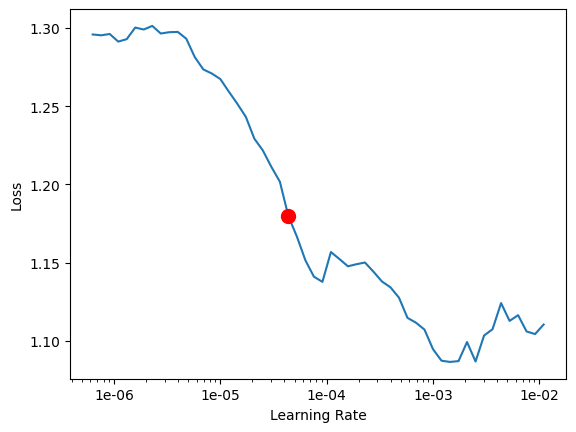

In [ ]:
learner.lr_find()
learner.recorder.plot(skip_end=10, suggestion=True)

#### V. Further Pretain The Last 4 Layers of BERT Model

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.863562,0.812183,0.635204,0.364796,00:04


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


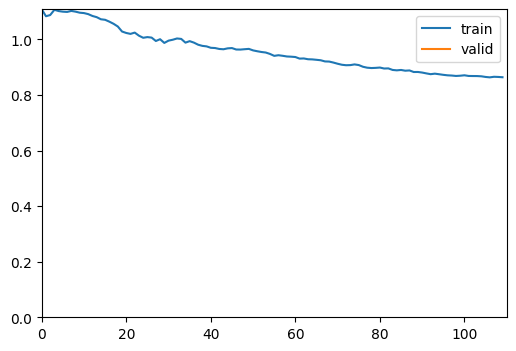

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.582276,0.539356,0.788265,0.211735,00:04


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


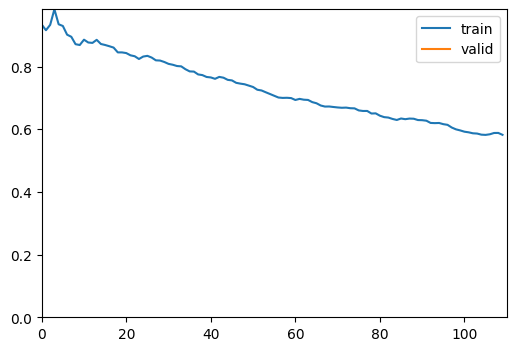

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.433155,0.394854,0.854592,0.145408,00:04


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


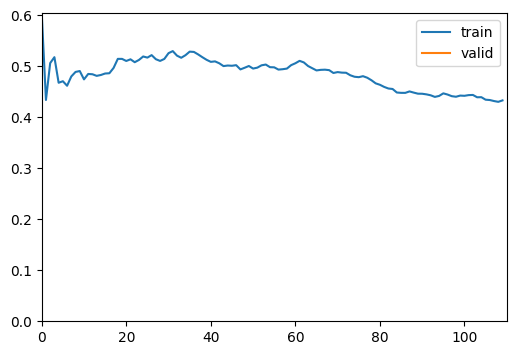

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.371291,0.355112,0.867347,0.132653,00:05


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


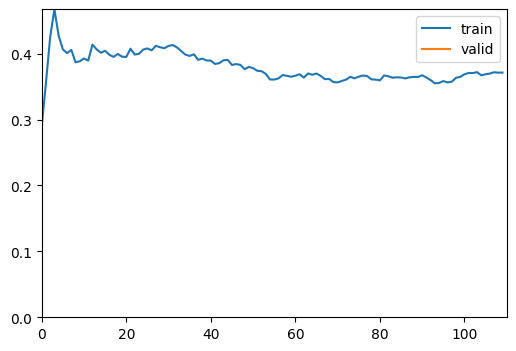

In [ ]:
lr = 2e-5
for i in range(1, 5):
  # Gradual Unfreezing the BERT 1 layer by 1 layer
  learner.freeze_to(-i)
  # Slanted Trianglular Learning Rate & Discriminative Layer Training
  learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr))

In [ ]:
learner.save('Further_pretrained_BERT')

In [ ]:
seed_all(seed)
learner.load('Further_pretrained_BERT');

#### VI. Evaluate the Further Pretained BERT Model

In [ ]:
neutral = list()
positive = list()
negative = list()
for i in range(len(test_set)):
  output = learner.predict(test_set.iloc[i, 0])
  neutral.append(output[2][0].tolist())
  positive.append(output[2][1].tolist())
  negative.append(output[2][2].tolist())

{Category 1: Neutral, Category 2: Postive, Category 3: Negative}

In [ ]:
df_array = np.array(test_set)
df_list = list(df_array[:, 0])
table = {'News_Headline':df_list, "Positive":positive, "Negative":negative, "Neutral":neutral}      
result_fpt_BERT = pd.DataFrame(table, columns = ["News_Headline", "Positive", "Negative", "Neutral"])
result_fpt_BERT['Prediction'] = result_fpt_BERT[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)
result_fpt_BERT['label'] = test_set['label'].copy()
result_fpt_BERT

,News_Headline,Positive,Negative,Neutral,Prediction,label
0,"Of this , EUR 38.8 mn was net interest income .",0.008606,0.002841,0.988552,Neutral,Neutral
1,The government has instead proposed an exchang...,0.013097,0.000526,0.986376,Neutral,Neutral
2,"Nordea Pankki Suomi Oyj , according to previou...",0.014318,0.000562,0.985120,Neutral,Neutral
3,Under the agreement GeoSentric will provide Gy...,0.105043,0.000292,0.894665,Neutral,Positive
4,Both operating profit and turnover for the six...,0.997065,0.000550,0.002385,Positive,Positive
...,...,...,...,...,...,...
917,"Finnish Suominen Flexible Packaging Ltd , owne...",0.325536,0.025831,0.648633,Neutral,Negative
918,"Alma Media holds 70 % of this company , the re...",0.002938,0.000434,0.996628,Neutral,Neutral
919,Less than ten people will face pension agreeme...,0.013236,0.265075,0.721690,Neutral,Neutral
920,"Purchase it for the 12MP snapper , if nothing ...",0.009806,0.002316,0.987879,Neutral,Neutral


              precision    recall  f1-score   support

    Negative       0.79      0.86      0.82       115
     Neutral       0.89      0.91      0.90       548
    Positive       0.86      0.78      0.81       259

    accuracy                           0.87       922
   macro avg       0.84      0.85      0.85       922
weighted avg       0.87      0.87      0.87       922



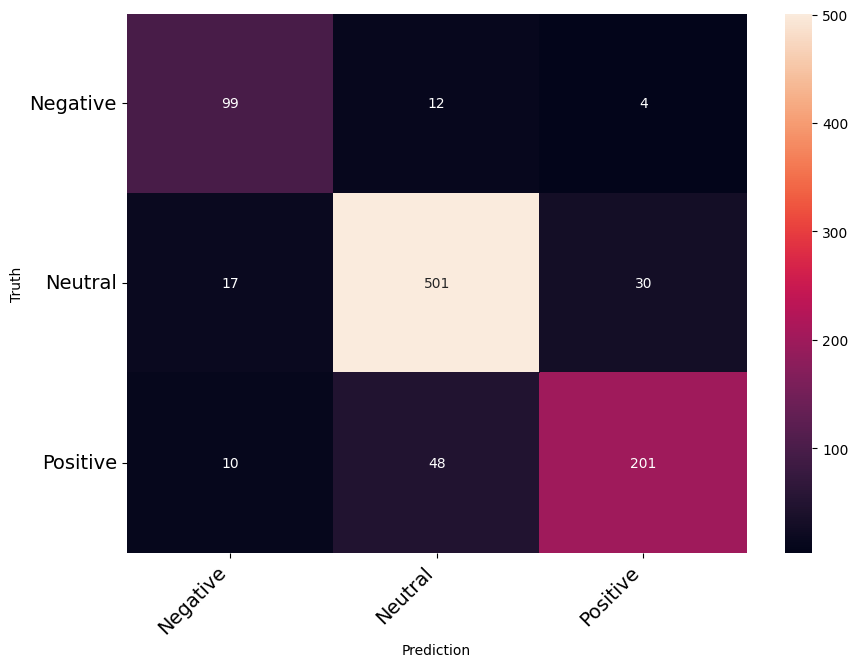

In [ ]:
print(classification_report(result_fpt_BERT['label'], result_fpt_BERT['Prediction']))
print_confusion_matrix(confusion_matrix(result_fpt_BERT['label'], result_fpt_BERT['Prediction']), ['Negative', 'Neutral', 'Positive'])

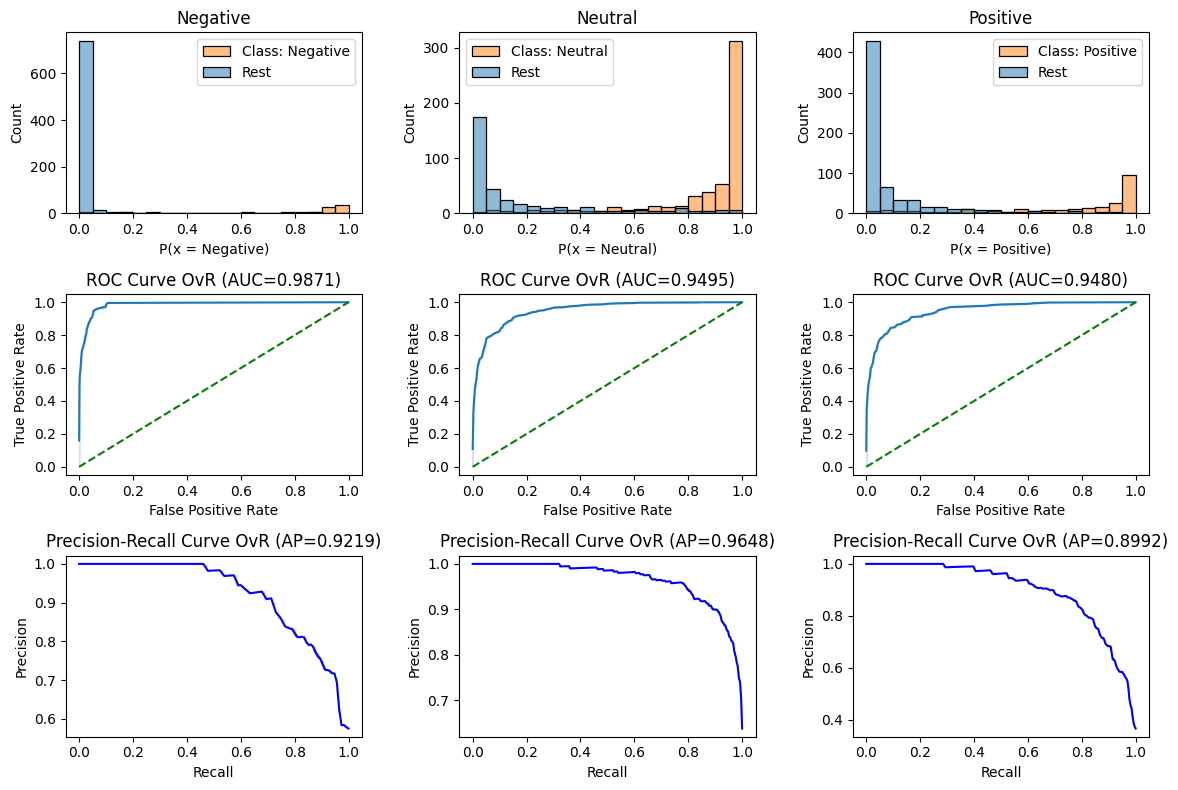

In [ ]:
plot_roc_pr_ovr(result_fpt_BERT)